In [1]:
!nvidia-smi

Thu May 13 06:43:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload() #upload kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
import time
time.sleep(5)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset
!unzip -q /content/sign-language-gesture-images-dataset.zip

Saving kaggle.json to kaggle.json
kaggle.json
 98% 186M/191M [00:02<00:00, 107MB/s] 
100% 191M/191M [00:02<00:00, 91.3MB/s]


In [2]:
#@title
import os 
foldersss = os.listdir("/content/Gesture Image Data")

for i in foldersss:
  print(len(os.listdir("/content/Gesture Image Data/"+i)))


1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1500


In [3]:
# !rm -r /content/Dataset

os.mkdir("/content/Dataset")
os.mkdir("/content/Dataset/train/")
os.mkdir("/content/Dataset/val/")
os.mkdir("/content/Dataset/test/")

for i in foldersss:
  os.mkdir("/content/Dataset/train/"+i)
  os.mkdir("/content/Dataset/val/"+i)
  os.mkdir("/content/Dataset/test/"+i)



In [4]:
# from shutil import copyfile
import cv2

for i in foldersss:
  for j in os.listdir("/content/Gesture Image Data/"+i)[:1125]:
    img = cv2.imread("/content/Gesture Image Data/"+i+"/"+j)
    cv2.imwrite("/content/Dataset/train/"+i+"/"+j, img)
    # copyfile("/content/Gesture Image Data/"+i+"/"+j, "/content/Dataset/train/"+i+"/")   # 75% for train
  for j in os.listdir("/content/Gesture Image Data/"+i)[1125:1425]:
    img = cv2.imread("/content/Gesture Image Data/"+i+"/"+j)
    cv2.imwrite("/content/Dataset/val/"+i+"/"+j, img)
    # copyfile("/content/Gesture Image Data/"+i+"/"+j, "/content/Dataset/val/"+i+"/")   # 20% for val
  for j in os.listdir("/content/Gesture Image Data/"+i)[1425:]:
    img = cv2.imread("/content/Gesture Image Data/"+i+"/"+j)
    cv2.imwrite("/content/Dataset/test/"+i+"/"+j, img)
    # copyfile("/content/Gesture Image Data/"+i+"/"+j, "/content/Dataset/test/"+i+"/")   # 5% for test
    


## Selecting Densnet121 and Mobilenet for smaller model size

# DENSENET121

In [15]:

import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [50, 50]

# train_path = '/content/drive/My Drive/Eclipse/Train'
# valid_path = '/content/drive/My Drive/Eclipse/Test'

# add preprocessing layer to the front of VGG
vgg = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
# useful for getting number of classes
folders = glob('/content/Dataset/train/*')
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax', name='predictions')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
# model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/Dataset/train/',
                                                 target_size = (50, 50),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory('/content/Dataset/val/',
                                            target_size = (50, 50),
                                            batch_size = 16,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/Dataset/test/',
                                            target_size = (50, 50),
                                            batch_size = 16,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the model
r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)



Found 41625 images belonging to 37 classes.
Found 11100 images belonging to 37 classes.
Found 2775 images belonging to 37 classes.
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2602/2602 [==============================] - 90s 33ms/step - loss: 0.6492 - accuracy: 0.8685 - val_loss: 0.0720 - val_accuracy: 0.9886
Epoch 2/10
2602/2602 [==============================] - 83s 32ms/step - loss: 0.0470 - accuracy: 0.9931 - val_loss: 0.0291 - val_accuracy: 0.9951
Epoch 3/10
2602/2602 [==============================] - 83s 32ms/step - loss: 0.0226 - accuracy: 0.9967 - val_loss: 0.0275 - val_accuracy: 0.9928
Epoch 4/10
2602/2602 [==============================] - 82s 32ms/step - loss: 0.0134 - accuracy: 0.9976 - val_loss: 0.0233 - val_accuracy: 0.9932
Epoch 5/10
2602/2602 [==============================] - 86s 33ms/step - loss: 0.0102 - accuracy: 0.9985 - val_loss: 0.0086 - val_accuracy: 0.9980
Epoch 6/10
2602/2602 [==============================] - 87s 34ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 7/10
2602/2602 [==============================] - 85s 33ms/step - loss: 0.0063 - accuracy: 0.9987 - val_loss: 0.0110 - val_accura

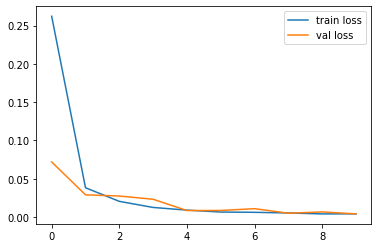

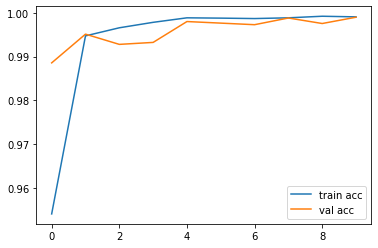

<Figure size 432x288 with 0 Axes>

In [16]:
# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [17]:
model.evaluate(test_set, batch_size=16)

174/174 [==============================] - 3s 18ms/step - loss: 0.0054 - accuracy: 0.9982


[0.0054022627882659435, 0.9981982111930847]

In [18]:
import tensorflow as tf
model.save('/content/drive/MyDrive/Gesture_DenseNet121.h5')

## Predictions of DenseNet121 on all test iamges

In [19]:
targets = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ_"
targets = list(targets)
len(targets)

37

In [20]:
import cv2
import numpy as np

images = []
true = []
for i in os.listdir("/content/Dataset/test"):
  for j in os.listdir("/content/Dataset/test/"+i):
    image = cv2.imread(os.path.join("/content/Dataset/test",i,j))
    images.append(image)
    true.append(i)

pred = model.predict(np.array(images).reshape((2775, 50, 50, 3))/255.0)


In [21]:

result = []
for i in range(0, pred.shape[0]):
  result.append(targets[np.argmax(pred[i])])
result


['3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 'K',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 'L',
 '_',
 'L',
 'L',
 '2',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'S',
 '_',
 '3',
 'S',
 'L',
 '_',
 'L',
 'L',
 '2',
 'L',
 'L',
 '_',
 'L',
 'L',
 'L',
 'H',
 'L',
 'L',
 'L',
 '3',
 'S',
 'L',
 'L',
 'L',
 'S',
 'L',
 '_',
 'L',
 'L',
 'L',
 'D',
 'L',
 'S',
 'L',
 'S',
 'L',
 'L',
 'L',
 'D',
 'S',
 'L',
 'L',
 'L',
 'L',
 'L',
 'D',
 'S',
 '_',
 'L',
 'L',
 'L',
 'L',
 'L',
 'S',
 'L',
 'S',
 'S',
 'L',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E'

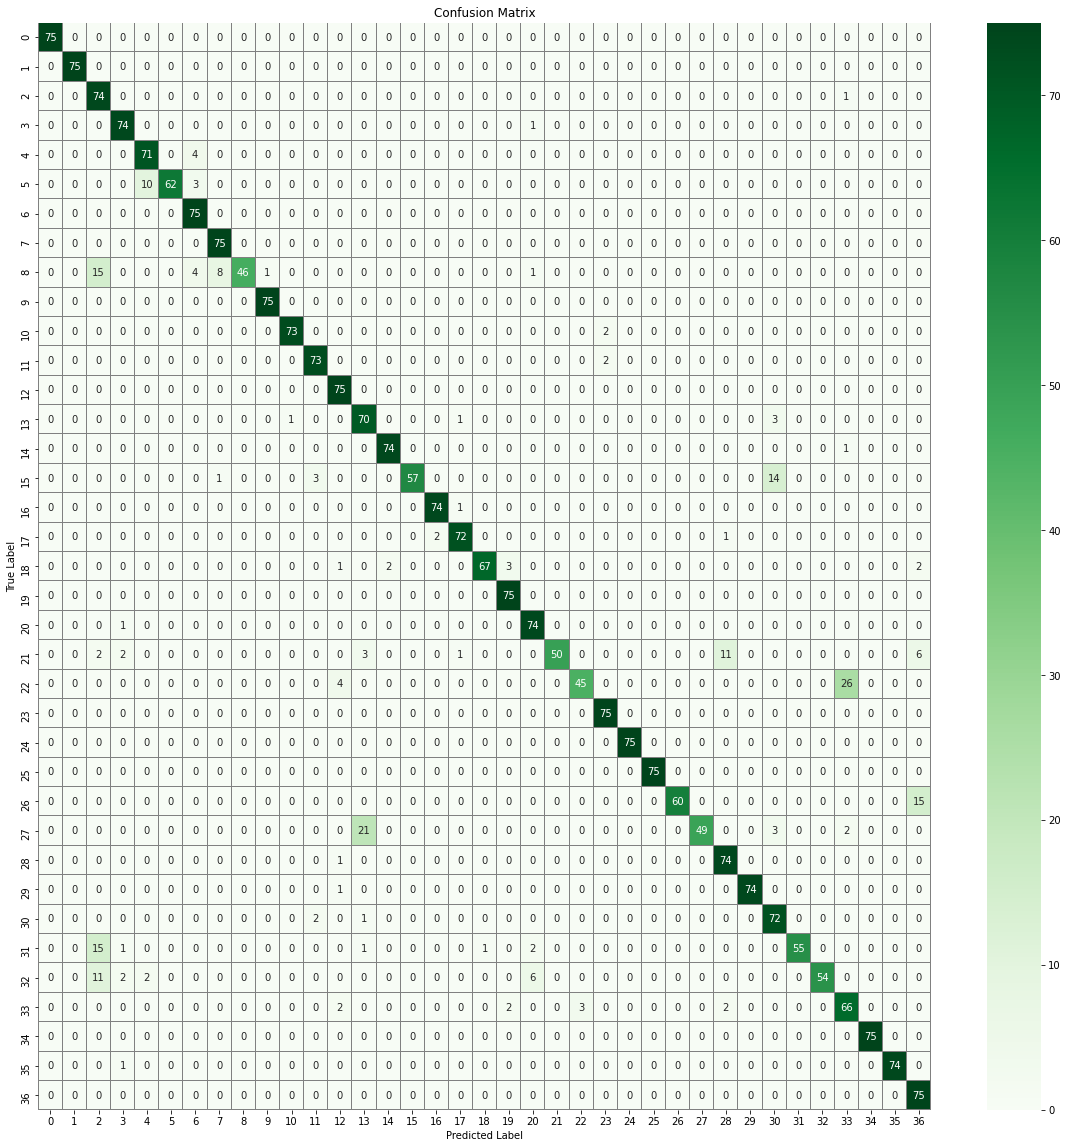

<Figure size 432x288 with 0 Axes>

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(true, result) 
# print(confusion_mtx)
# plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.metrics import classification_report

print(classification_report(true, result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75
           2       0.63      0.99      0.77        75
           3       0.91      0.99      0.95        75
           4       0.86      0.95      0.90        75
           5       1.00      0.83      0.91        75
           6       0.87      1.00      0.93        75
           7       0.89      1.00      0.94        75
           8       1.00      0.61      0.76        75
           9       0.99      1.00      0.99        75
           A       0.99      0.97      0.98        75
           B       0.94      0.97      0.95        75
           C       0.89      1.00      0.94        75
           D       0.73      0.93      0.82        75
           E       0.97      0.99      0.98        75
           F       1.00      0.76      0.86        75
           G       0.97      0.99      0.98        75
           H       0.96    

# MOBILENET_V2

In [24]:

import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [50, 50]

# train_path = '/content/drive/My Drive/Eclipse/Train'
# valid_path = '/content/drive/My Drive/Eclipse/Test'

# add preprocessing layer to the front of VGG
vgg = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
# useful for getting number of classes
folders = glob('/content/Dataset/train/*')
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
# model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/Dataset/train/',
                                                 target_size = (50, 50),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory('/content/Dataset/val/',
                                            target_size = (50, 50),
                                            batch_size = 16,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/Dataset/test/',
                                            target_size = (50, 50),
                                            batch_size = 16,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the model
r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)



Found 41625 images belonging to 37 classes.
Found 11100 images belonging to 37 classes.
Found 2775 images belonging to 37 classes.
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2602/2602 [==============================] - 63s 23ms/step - loss: 0.2744 - accuracy: 0.9255 - val_loss: 0.0746 - val_accuracy: 0.9768
Epoch 2/10
2602/2602 [==============================] - 59s 23ms/step - loss: 0.0369 - accuracy: 0.9885 - val_loss: 0.0251 - val_accuracy: 0.9924
Epoch 3/10
2602/2602 [==============================] - 59s 23ms/step - loss: 0.0312 - accuracy: 0.9916 - val_loss: 0.0405 - val_accuracy: 0.9929
Epoch 4/10
2602/2602 [==============================] - 59s 23ms/step - loss: 0.0282 - accuracy: 0.9919 - val_loss: 0.0383 - val_accuracy: 0.9914
Epoch 5/10
2602/2602 [==============================] - 60s 23ms/step - loss: 0.0199 - accuracy: 0.9950 - val_loss: 0.0398 - val_accuracy: 0.9907
Epoch 6/10
2602/2602 [==============================] - 60s 23ms/step - loss: 0.0236 - accuracy: 0.9944 - val_loss: 0.0228 - val_accuracy: 0.9952
Epoch 7/10
2602/2602 [==============================] - 60s 23ms/step - loss: 0.0232 - accuracy: 0.9945 - val_loss: 0.0456 - val_accura

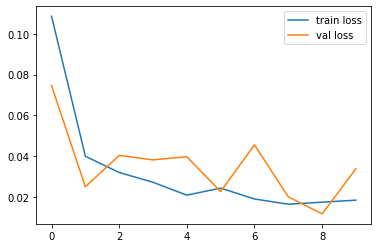

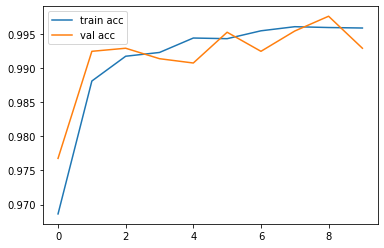

<Figure size 432x288 with 0 Axes>

In [25]:
# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [26]:
model.evaluate(test_set, batch_size=16)

174/174 [==============================] - 2s 11ms/step - loss: 0.0358 - accuracy: 0.9942


[0.03577153757214546, 0.9942342638969421]

In [27]:
import tensorflow as tf
model.save('/content/drive/MyDrive/Gesture_MobileNetV2.h5')

## Predictions of MobileNetV2 on all test iamges

In [28]:
targets = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ_"
targets = list(targets)
len(targets)

37

In [29]:
import cv2
import numpy as np

images = []
true = []
for i in os.listdir("/content/Dataset/test"):
  for j in os.listdir("/content/Dataset/test/"+i):
    image = cv2.imread(os.path.join("/content/Dataset/test",i,j))
    images.append(image)
    true.append(i)

pred = model.predict(np.array(images).reshape((2775, 50, 50, 3))/255.0)


In [30]:

result = []
for i in range(0, pred.shape[0]):
  result.append(targets[np.argmax(pred[i])])
result


['3',
 '3',
 '3',
 '4',
 '3',
 '3',
 '4',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '4',
 '3',
 '3',
 '4',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '4',
 '3',
 '3',
 '3',
 '3',
 '9',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '9',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '4',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 '1',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 '1',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'K',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E'

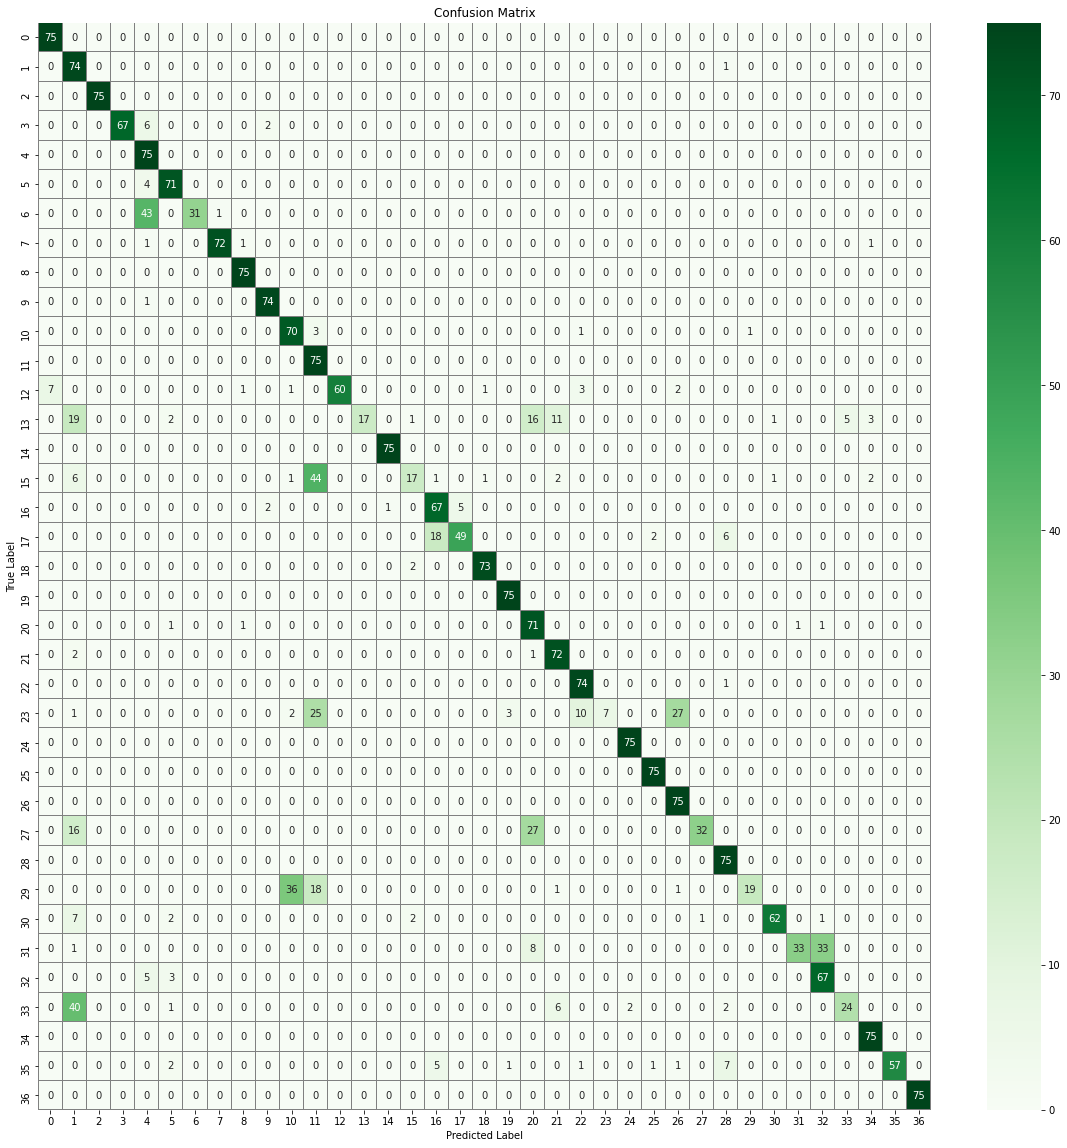

<Figure size 432x288 with 0 Axes>

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(true, result) 
# print(confusion_mtx)
# plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [32]:
from sklearn.metrics import classification_report

print(classification_report(true, result))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        75
           1       0.45      0.99      0.61        75
           2       1.00      1.00      1.00        75
           3       1.00      0.89      0.94        75
           4       0.56      1.00      0.71        75
           5       0.87      0.95      0.90        75
           6       1.00      0.41      0.58        75
           7       0.99      0.96      0.97        75
           8       0.96      1.00      0.98        75
           9       0.95      0.99      0.97        75
           A       0.64      0.93      0.76        75
           B       0.45      1.00      0.62        75
           C       1.00      0.80      0.89        75
           D       1.00      0.23      0.37        75
           E       0.99      1.00      0.99        75
           F       0.77      0.23      0.35        75
           G       0.74      0.89      0.81        75
           H       0.91    

## Selecting DenseNet121 for best performance over accuracy as well as f1_score

In [ ]:
# For prob of classes
# pred.argmax(), pred[0][pred.argmax()]